In [2]:
import os

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor

from datasets.SHHS_dataset_timeonly import SHHS_dataset_1, EEGdataModule

from models.logistic_regression import LogisticRegression
from models.simclr_model import CNNmodel_SimCLR
from models.conv_model_simple import CNNmodel_supervised_simple
import torch
import torch.utils.data as data

from copy import deepcopy
from utils.load_and_save_model import load_model
from utils.encoder_function import prepare_data_features


## Define dataset: 3 patients for training, 1 for validation and 10 for testing

In [4]:
data_args = {
  "DATA_PATH": "../../thesis01/data/",
  "data_split": [3, 1],
  "first_patient": 1,
  "num_patients_train": 12,
  "num_patients_test": 20,
  "batch_size": 64,
  "num_workers": 12
}

device = torch.device('cpu')
dm = EEGdataModule(**data_args)  # Load datamodule
dm.setup()

Couldn't find file at path:  ../../thesis01/data/n0014_eeg.mat


## Run data through the pretrained SimCLR encoder to get the representations
- The SimCLR model was pretrained on 100 patients (+50 for validation)

In [5]:
encoder_path = "../trained_models/simclr05.ckpt"
pretrained_model = load_model(CNNmodel_SimCLR, encoder_path)  # Load pretrained simclr model
train_ds = prepare_data_features(pretrained_model, dm.train_dataloader(), device)
val_ds = prepare_data_features(pretrained_model, dm.val_dataloader(), device)
test_ds = prepare_data_features(pretrained_model, dm.test_dataloader(), device)

  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/288 [00:00<?, ?it/s]

## Analyse the features: histogram and t-SNE plot

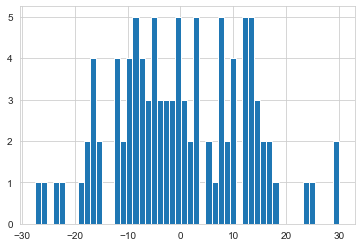

In [6]:
import matplotlib.pyplot as plt
import numpy as np
feature = train_ds.__getitem__(0)[0]
plt.hist(np.asarray(feature), bins=50)
plt.show()

In [9]:
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd
tsne = TSNE(n_components=2, n_iter=300, verbose=1, perplexity=125)
x, y = train_ds.tensors
tsne_results = tsne.fit_transform(x)

C:\Users\tomsm\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\tomsm\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 376 nearest neighbors...
[t-SNE] Indexed 8889 samples in 0.001s...
[t-SNE] Computed neighbors for 8889 samples in 2.079s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8889
[t-SNE] Computed conditional probabilities for sample 2000 / 8889
[t-SNE] Computed conditional probabilities for sample 3000 / 8889
[t-SNE] Computed conditional probabilities for sample 4000 / 8889
[t-SNE] Computed conditional probabilities for sample 5000 / 8889
[t-SNE] Computed conditional probabilities for sample 6000 / 8889
[t-SNE] Computed conditional probabilities for sample 7000 / 8889
[t-SNE] Computed conditional probabilities for sample 8000 / 8889
[t-SNE] Computed conditional probabilities for sample 8889 / 8889
[t-SNE] Mean sigma: 19.251540
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.223106
[t-SNE] KL divergence after 300 iterations: 2.250006


<AxesSubplot:xlabel='comp-1', ylabel='comp-2'>

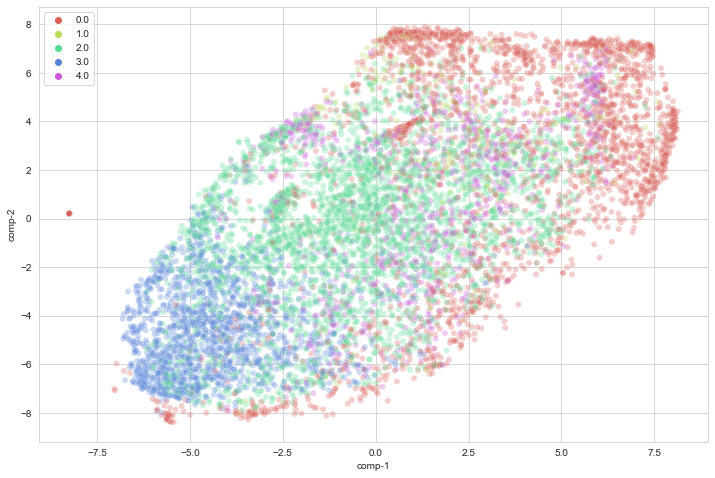

In [10]:
df = pd.DataFrame()
df['comp-1'] = tsne_results[:,0]
df['comp-2'] = tsne_results[:,1]
df["y"] = y
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x="comp-1", y="comp-2",
    hue=df.y.tolist(),
    palette=sns.color_palette("hls", 5),
    data=df,
    legend="full",
    alpha=0.3
)

## Train a logistic classifier on top

In [11]:
trainer_args = {
    "CHECKPOINT_PATH": "../checkpoints",
    "max_epochs": 20,
    "batch_size": 64,
    "num_workers": 12
}
trainer_logistic = pl.Trainer(default_root_dir=os.path.join(trainer_args['CHECKPOINT_PATH'], "LogisticRegression"),
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         max_epochs=trainer_args['max_epochs'],
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode='max', monitor='val_acc'),
                                    LearningRateMonitor("epoch")],
                         enable_progress_bar=True,
                         check_val_every_n_epoch=2)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [12]:
train_loader = data.DataLoader(train_ds, batch_size=trainer_args['batch_size'], shuffle=True,
                                   drop_last=False, pin_memory=True, num_workers=trainer_args['num_workers'])
val_loader = data.DataLoader(val_ds, batch_size=trainer_args['batch_size'], shuffle=True,
                                 drop_last=False, pin_memory=True, num_workers=trainer_args['num_workers'])
test_loader = data.DataLoader(test_ds, batch_size=trainer_args['batch_size'], shuffle=False,
                                  drop_last=False, pin_memory=True, num_workers=trainer_args['num_workers'])

In [13]:
log_model = LogisticRegression(feature_dim=100,
                               lr=1e-3,
                               weight_decay=1e-4,
                               max_epochs=20)

In [14]:
trainer_logistic.fit(log_model, train_loader, val_loader)


  | Name  | Type   | Params
---------------------------------
0 | model | Linear | 505   
---------------------------------
505       Trainable params
0         Non-trainable params
505       Total params
0.002     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

C:\Users\tomsm\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:489: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


In [15]:
print(trainer_logistic.checkpoint_callback.best_model_path)
model = LogisticRegression.load_from_checkpoint(trainer_logistic.checkpoint_callback.best_model_path)
test_result = trainer_logistic.test(model, test_loader, verbose=False)
print(test_result)

..\checkpoints\LogisticRegression\lightning_logs\version_15\checkpoints\epoch=11-step=1668.ckpt


Testing: 0it [00:00, ?it/s]

[{'test_loss': 0.8470638990402222, 'test_acc': 0.5398825407028198}]


## Train a supervised model with the same dataset for comparison

In [20]:
trainer_args_supervised = {
    "CHECKPOINT_PATH": "../checkpoints",
    "max_epochs": 15,
    "save_name": "supervised02"
}

trainer_supervised = pl.Trainer( default_root_dir = os.path.join(trainer_args_supervised['CHECKPOINT_PATH'], trainer_args_supervised['save_name']),
                                 accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                                 devices=1,  # How many GPUs/CPUs to use
                                 callbacks=[
                                     ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc", save_last=True),
                                     # Save the best checkpoint based on the maximum val_acc recorded. Saves only weights and not optimizer
                                     LearningRateMonitor("epoch")],  # Log learning rate every epoch
                                 enable_progress_bar=True,
                                 max_epochs=trainer_args_supervised['max_epochs']
                                         )

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [21]:
from models.conv_model_simple import CNNmodel_supervised_simple
cnn_encoder_hparams = {
    "conv_filters": [32, 64, 64],
    "representation_dim": 100
}

optim_hparams= {
    "lr": 1e-4,
    "weight_decay": 1e-4
  }

sup_model = CNNmodel_supervised_simple(cnn_encoder_hparams, optim_hparams)

In [22]:
trainer_supervised.fit(sup_model, dm.train_dataloader(), dm.val_dataloader())


  | Name        | Type             | Params | In sizes     | Out sizes
----------------------------------------------------------------------------
0 | loss_module | CrossEntropyLoss | 0      | ?            | ?        
1 | head        | CNN_head         | 2.4 M  | [1, 1, 3000] | [1, 100] 
2 | classifier  | Linear           | 505    | [1, 100]     | [1, 5]   
3 | model       | Sequential       | 2.4 M  | [1, 1, 3000] | [1, 5]   
----------------------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.678     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

C:\Users\tomsm\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:489: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.


In [23]:
print(trainer_supervised.checkpoint_callback.best_model_path)
sup_model = CNNmodel_supervised_simple.load_from_checkpoint(trainer_supervised.checkpoint_callback.best_model_path)
test_result = trainer_supervised.test(sup_model, dm.test_dataloader(), verbose=False)
print(test_result)

..\checkpoints\supervised02\lightning_logs\version_4\checkpoints\epoch=5-step=834.ckpt


Testing: 0it [00:00, ?it/s]

[{'test_acc': 0.6837444305419922}]


## Comparison with random weights

In [17]:
cnn_encoder_hparams = {
    "conv_filters": [32, 64, 64],
    "representation_dim": 100
}

projection_head_hparams = {
    "use_MLP": 0,
    "hidden_dim": 200
}

optim_hparams = {
    "lr": 5e-4,
    "weight_decay": 1e-4,
    "max_epochs": 30
}
random_model = CNNmodel_SimCLR(cnn_encoder_hparams, projection_head_hparams, optim_hparams, temperature=0.05)
train_ds_random = prepare_data_features(random_model, dm.train_dataloader(), device)
val_ds_random = prepare_data_features(random_model, dm.val_dataloader(), device)
test_ds_random = prepare_data_features(random_model, dm.test_dataloader(), device)

train_loader_random = data.DataLoader(train_ds_random, 64, shuffle=True, num_workers=12)
val_loader_random = data.DataLoader(val_ds_random, 64, shuffle=True, num_workers=12)
test_loader_random = data.DataLoader(test_ds_random, 64, shuffle=True, num_workers=12)


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/288 [00:00<?, ?it/s]

C:\Users\tomsm\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\tomsm\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2760 samples in 0.001s...
[t-SNE] Computed neighbors for 2760 samples in 0.221s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2760
[t-SNE] Computed conditional probabilities for sample 2000 / 2760
[t-SNE] Computed conditional probabilities for sample 2760 / 2760
[t-SNE] Mean sigma: 0.079437
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.432533
[t-SNE] KL divergence after 300 iterations: 2.898009


<AxesSubplot:xlabel='comp-1', ylabel='comp-2'>

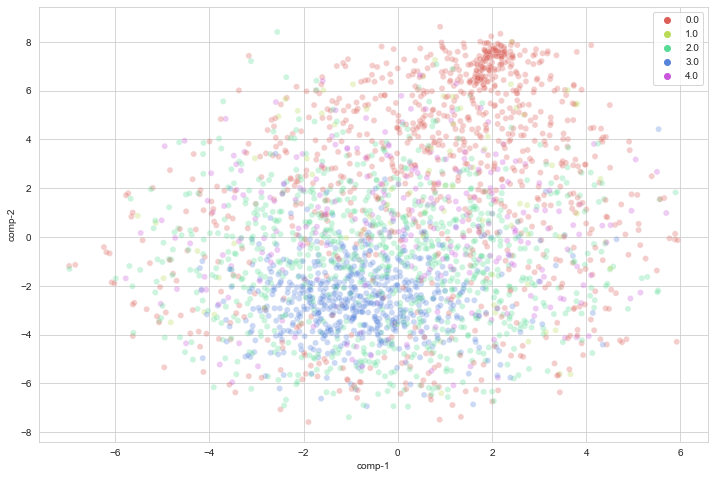

In [19]:
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
tsne_random = TSNE(n_components=2, n_iter=300, verbose=1, perplexity=50)
x, y = train_ds_random.tensors
tsne_results = tsne_random.fit_transform(x)
df = pd.DataFrame()
df['comp-1'] = tsne_results[:,0]
df['comp-2'] = tsne_results[:,1]
df["y"] = y
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x="comp-1", y="comp-2",
    hue=df.y.tolist(),
    palette=sns.color_palette("hls", 5),
    data=df,
    legend="full",
    alpha=0.3
)

## Train a logistic classifier on top

In [18]:
trainer_logistic.fit(log_model, train_loader_random, val_loader_random)

C:\Users\tomsm\anaconda3\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:616: UserWarning: Checkpoint directory ..\checkpoints\LogisticRegression\lightning_logs\version_15\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name  | Type   | Params
---------------------------------
0 | model | Linear | 505   
---------------------------------
505       Trainable params
0         Non-trainable params
505       Total params
0.002     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

C:\Users\tomsm\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:489: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=20` reached.


In [19]:
print(trainer_logistic.checkpoint_callback.best_model_path)
model = LogisticRegression.load_from_checkpoint(trainer_logistic.checkpoint_callback.best_model_path)
test_result = trainer_logistic.test(model, test_loader_random, verbose=False)
print(test_result)

..\checkpoints\LogisticRegression\lightning_logs\version_15\checkpoints\epoch=11-step=1668.ckpt


C:\Users\tomsm\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:489: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

[{'test_loss': 1.6051626205444336, 'test_acc': 0.22365225851535797}]


## Finally, lets see how a fine-tuned supervised model performs

In [9]:
cnn_encoder_hparams = {
    "conv_filters": [32, 64, 64],
    "representation_dim": 100
}

projection_head_hparams = {
    "use_MLP": 0,
    "hidden_dim": 200
}

optim_hparams = {
    "lr": 1e-3,
    "weight_decay": 1e-4,
}
finetuned_model = CNNmodel_supervised_simple(cnn_encoder_hparams, optim_hparams)
encoder = deepcopy(pretrained_model.f)
finetuned_model.head = encoder

In [10]:
trainer_supervised.fit(finetuned_model, dm.train_dataloader(), dm.val_dataloader())


  | Name        | Type             | Params | In sizes     | Out sizes
----------------------------------------------------------------------------
0 | loss_module | CrossEntropyLoss | 0      | ?            | ?        
1 | head        | CNN_head         | 2.4 M  | ?            | ?        
2 | classifier  | Linear           | 505    | [1, 100]     | [1, 5]   
3 | model       | Sequential       | 2.4 M  | [1, 1, 3000] | [1, 5]   
----------------------------------------------------------------------------
4.8 M     Trainable params
0         Non-trainable params
4.8 M     Total params
19.354    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

C:\Users\tomsm\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:489: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
C:\Users\tomsm\anaconda3\lib\site-packages\pytorch_lightning\trainer\trainer.py:1892: PossibleUserWarning: The number of training batches (44) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.


In [11]:
print(trainer_supervised.checkpoint_callback.best_model_path)
sup_model = CNNmodel_supervised_simple.load_from_checkpoint(trainer_supervised.checkpoint_callback.best_model_path)
test_result = trainer_supervised.test(sup_model, dm.test_dataloader(), verbose=False)
print(test_result)

..\checkpoints\supervised02\lightning_logs\version_3\checkpoints\epoch=11-step=528.ckpt


Testing: 0it [00:00, ?it/s]

[{'test_acc': 0.5610964298248291}]


The finetuned supervised model performs even worse than the supervised model itself, maybe this is due to training it too fast or something?